In [1]:
from numba import jit
import numpy as np
from numba import jit, int32, float32, types, typed
from numba.typed import List
from numba.experimental import jitclass
import matplotlib.pyplot as plt

In [124]:
gyro_radius = 3.086*10**17 # [m]; 10 PeV proton in 1 mucro Gauss B field
c = 3*10**8 # [m^2/s]
v = c
tau_step = gyro_radius/c
delta_rho_div_phi = 0.5 # (delta_rho / delta_phi)

In [125]:
@jit(nopython=True, fastmath=True, parallel = True)
def propagate(particle_id, spheres):
    pos = [0.0, 0.0, 0.0]
    phi = 0.0
    particle_info = []
    direction = [1,1,1]
    isotrop = False
    distance = 0.0
    
    for i in range(1,10**5): 
        pos_prev = pos
        
        ### change direction #############################################################
        if np.random.random() < 0.0002:
            direction[0] = -1*direction[0]
        if np.random.random() < 0.003:
            direction[1] = -1*direction[1]
        if np.random.random() < 0.003:
            direction[2] = -1*direction[2]
            
        ### move in updated direction ####################################################
        if isotrop:
            normalize = (direction[0]**2 + direction[1]**2 + direction[2]**2)**0.5
            time = i # ToDo change this (need to incooperate steplength)
            for j in range(3):
                pos[j] = pos[j] + direction[j]/normalize
        else:
            phi_old = phi
            #phi = phi_old + 2 * np.pi / steps_per_gyration
            delta_r_squared = 2/3 * v**2 * tau_step**2  # delta_r_squared = delta_phi_squared + delta_rho_squared
            ### move in phi direction 
            delta_r_phi_squared = delta_r_squared / (1 + delta_rho_div_phi**2)
            delta_phi = np.arccos(1 - delta_r_phi_squared / (2 * gyro_radius**2))
            phi = phi_old + delta_phi * direction[0]
            chi_x = gyro_radius * (np.cos(phi) - np.cos(phi_old)) 
            chi_y = gyro_radius * (np.sin(phi) - np.sin(phi_old))
            
            
            ### distance_travelled = 2*pi*gyro_radius / steps_per_gyration (only for small phi)
            #delta_x = gyro_radius * (np.cos(phi) - np.cos(phi_old)) * direction[0]
            #delta_y = gyro_radius * (np.sin(phi) - np.sin(phi_old)) * direction[0]
            #delta_r_1_squared = delta_x**2 + delta_y**2
            
            
            ### move in rho direction
            delta_rho = delta_rho_div_phi * delta_r_phi_squared**0.5
            #print(delta_rho)
            chi_x = chi_x + np.cos(phi) * direction[1] * delta_rho
            chi_y = chi_y + np.sin(phi) * direction[1] * delta_rho
            ### distance_travelled = 2*pi*gyro_radius / steps_per_gyration
            #delta_x = delta_x + np.cos(phi) * direction[1] * delta_rho
            #delta_y = delta_y + np.sin(phi) * direction[1] * delta_rho
            #delta_r_2_squared = delta_x**2 + delta_y**2
            
            
            ### move in z direction as much as in the x or y-direction
            chi_z = direction[2] * v * tau_step / 3**0.5
            #delta_z = direction[2] * ((delta_x**2+delta_y**2)/2)**0.5
            
            ### move !!!
            pos[0] = pos[0] + chi_x
            pos[1] = pos[1] + chi_y
            pos[2] = pos[2] + chi_z
            ### distance_travelled
            
            distance_in_step = (3*chi_z**2)**0.5
            distance = distance + distance_in_step
            #print(phi_old, delta_r_phi_squared, chi_x**2+chi_y**2, chi_z**2)

        
        ### observer ####################################################################
        r2_prev = pos_prev[0]**2+pos_prev[1]**2+pos_prev[2]**2
        r2 = pos[0]**2+pos[1]**2+pos[2]**2
        if i<1000 or i%500 == 0:
            particle_info.append([particle_id, i, distance, pos[0], pos[1], pos[2], -1.0])
        for r2_sphere in spheres:
            if r2_prev > r2_sphere and r2 <= r2_sphere or r2_prev < r2_sphere and r2 >= r2_sphere:
                particle_info.append([particle_id, i, distance, pos[0], pos[1], pos[2], r2_sphere*1.0])
        
    return particle_info

In [126]:
@jit(nopython=True)
def many_particles(observer_spheres):
    data = [[0.0, 0.0, 0.0, 0.0, -1.0]]
    for i in range(10**2):
        particle_id = i
        data_new = propagate(particle_id, observer_spheres)
        data = data + data_new

    print('finished')
    return data

In [127]:
observer_spheres = np.array([-1.0]) 
%time data = many_particles(observer_spheres)

<ipython-input-126-e81c6bc2e63b>:6: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-125-34424bb701a6>", line 2:
@jit(nopython=True, fastmath=True, parallel = True)
def propagate(particle_id, spheres):
^

  data_new = propagate(particle_id, observer_spheres)


finished
Wall time: 4.41 s


In [128]:
import pandas as pd
df = pd.DataFrame(data[1:])
df.columns = ['id', 'i', 'd', 'x', 'y', 'z', 'radius']
df

,id,i,d,x,y,z,radius
0,0.0,1.0,3.086000e+17,3.421775e+14,2.864186e+17,1.781703e+17,-1.0
1,0.0,2.0,6.172000e+17,-1.941341e+17,4.966915e+17,3.563406e+17,-1.0
2,0.0,3.0,9.258000e+17,-4.797081e+17,5.186732e+17,5.345109e+17,-1.0
3,0.0,4.0,1.234400e+18,-7.040738e+17,3.406401e+17,7.126812e+17,-1.0
4,0.0,5.0,1.543000e+18,-7.475693e+17,5.754324e+16,8.908515e+17,-1.0
...,...,...,...,...,...,...,...
119695,99.0,97500.0,3.008850e+22,-4.710691e+18,1.408971e+18,-1.376187e+21,-1.0
119696,99.0,98000.0,3.024280e+22,-4.940697e+18,1.220674e+18,-1.320242e+21,-1.0
119697,99.0,98500.0,3.039710e+22,-5.057677e+18,1.959966e+18,-1.394717e+21,-1.0
119698,99.0,99000.0,3.055140e+22,-5.416067e+18,1.262600e+18,-1.483802e+21,-1.0


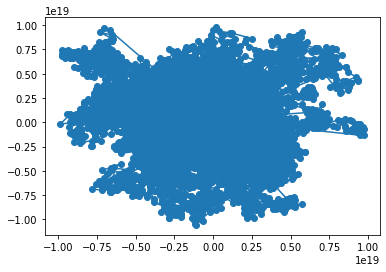

In [129]:
plt.scatter(df['x'], df['y'])
plt.plot(df['x'], df['y'])

In [130]:
# remove duplicated elements from list of times 
steps = []
[steps.append(i) for i in df['i'] if i not in steps]
kappa_perp = []
kappa_para = []
distance = []
for i in steps:
    df_i = df.loc[df['i'] == i] # all particles per step
    kappa_perp.append(np.mean(np.array((df_i['x'].values**2+df_i['y'].values**2))/(4*np.array(df_i['d'].values))*c))
    kappa_para.append(np.mean(np.array(df_i['z'].values**2)/(2*np.array(df_i['d'].values))*c))
    distance.append(np.mean(df_i['d'].values))

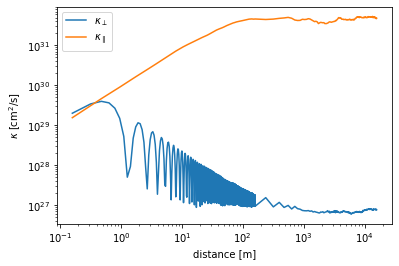

In [131]:
from modules.Plotter import Plotter
import matplotlib.pyplot as plt
### each step is one second -> times = steps
plt.plot(np.array(distance) / (2 * np.pi * gyro_radius), np.array(kappa_perp)*10**4, label='$\kappa_\perp$')
plt.plot(np.array(distance) / (2 * np.pi * gyro_radius), np.array(kappa_para)*10**4, label='$\kappa_\parallel$')
plt.xlabel('distance [m]')
plt.ylabel('$\kappa$ [cm$^2$/s]')
plt.legend()
plt.loglog()
plt.show()

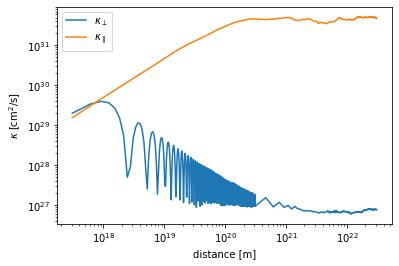

In [132]:
from modules.Plotter import Plotter
import matplotlib.pyplot as plt
### each step is one second -> times = steps
plt.plot(distance, np.array(kappa_perp)*10**4, label='$\kappa_\perp$')
plt.plot(distance, np.array(kappa_para)*10**4, label='$\kappa_\parallel$')
plt.xlabel('distance [m]')
plt.ylabel('$\kappa$ [cm$^2$/s]')
plt.legend()
plt.loglog()
plt.show()

In [53]:
print(np.log10(np.mean(kappa_para[-10:]))-np.log10(np.mean(kappa_perp[-10:])))

5.482729484002405


### Lessons learned

The parameter steps_per_gyration moves the first minimum linearly, which is expected -> increasing by 10 moves minima by factor 10 to right

In [18]:
for i in range(1,len(distance)-1):
    print(distance[i]-distance[i-1])

6.918033623070519e+16
6.918033623070525e+16
6.918033623070522e+16
6.918033623070534e+16
6.913815377127802e+16
6.905378885242394e+16
6.905378885242355e+16
6.901160639299706e+16
6.896942393356941e+16
6.896942393356941e+16
6.896942393356928e+16
6.896942393356941e+16
6.896942393357005e+16
6.896942393356954e+16
6.896942393356877e+16
6.896942393357018e+16
6.896942393356979e+16
6.896942393356954e+16
6.896942393356954e+16
6.892724147414195e+16
6.888505901471642e+16
6.888505901471488e+16
6.888505901471437e+16
6.888505901471667e+16
6.888505901471462e+16
6.888505901471616e+16
6.888505901471437e+16
6.888505901471437e+16
6.888505901471642e+16
6.888505901471488e+16
6.884287655528832e+16
6.884287655528858e+16
6.884287655528781e+16
6.884287655528858e+16
6.884287655528755e+16
6.884287655528755e+16
6.880069409586125e+16
6.880069409586074e+16
6.875851163643443e+16
6.875851163643443e+16
6.875851163643392e+16
6.871632917700659e+16
6.87163291770071e+16
6.871632917700506e+16
6.871632917700813e+16
6.871632917

In [73]:
np.arccos(0.2)

1.369438406004566

In [76]:
np.cos(np.pi)

-1.0